In [43]:
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

plt.style.use('ggplot')

# Forecasting Chl-a for Lake Vansjø

We have daily precipitation and air temperature data from roughly 1970 to 2018, and would like to use this to help forecast Chl-a. The Chl-a record begins in mid-1980 and measurements are usually taken a few times per year during the late spring and summer. The most recent Chl-a data are from 2016.

In principle we could build a daily time series model, but then the vast majority of the Chl-a record is missing. I also suspect that Chl-a does not respond immediately to daily fluctuations in rainfall and air temperature, so it probably makes more sense to aggregate the temperature and rainfall records to monthly resolution (thereby removing a lot of the noise), and then attempt to relate this to the Chl-a record. In the code below I'll explore both options.

## 1. Read data

In [2]:
# Read data
df = pd.read_csv('../../../data/Vansjø_daily_data.csv', encoding='utf-8')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Get just cols of interest
df = df[['Date', 'Pptn', 'Temp', 'chl-a_lake']]
df.columns = ['ds', 'Pptn', 'Temp', 'y']

df.head()

,ds,Pptn,Temp,y
0,1970-09-01,0.0,13.35,NaN
1,1970-09-02,13.6,13.15,NaN
2,1970-09-03,0.7,11.30,NaN
3,1970-09-04,0.0,11.10,NaN
4,1970-09-05,0.0,10.90,NaN


## 2. Daily model without predictors

I've turned off daily cycles, because we don't have times in our dataset. I guess Chl-a shouldn't respond to weekly cycles either, but I've left these in for now.

In [4]:
# Fit model
m = Prophet(growth='linear',                 # Or 'logistic'
            seasonality_mode='additive',     # Or 'multiplicative'
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True)         # Or number. Bigger => more flexibility in seasonality
m.fit(df)

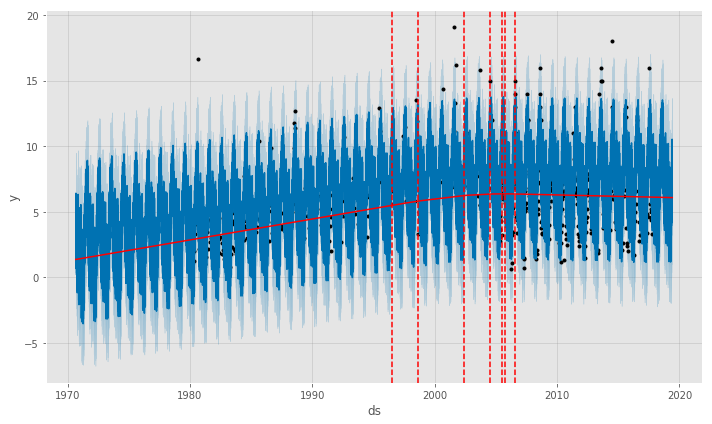

In [5]:
# Plot results, inc. 12 month forecast
future = m.make_future_dataframe(periods=365, freq='D')
fcst = m.predict(future)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

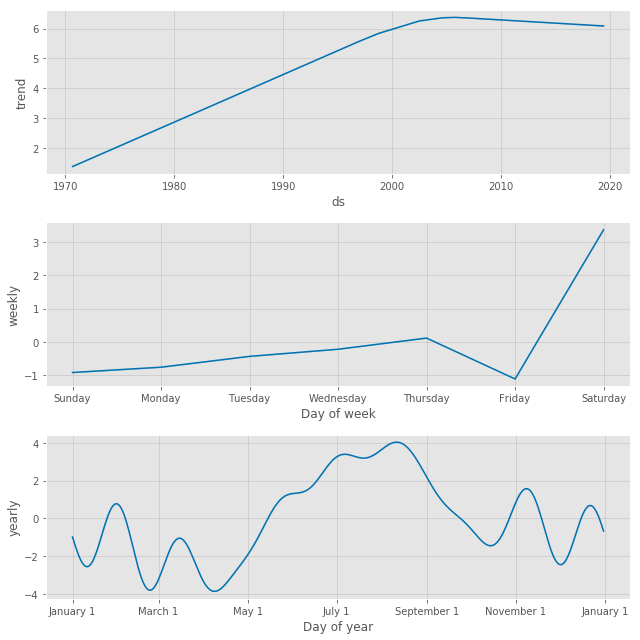

In [6]:
# Plot components
fig2 = m.plot_components(fcst)

The model predicts a steadily increasing trend in Chl-a until the early 2000s, followed by a levelling-of (and maybe even a slight decrease) in recent years. There is a big peak in seasonality on Saturdays, which seems odd. Were most samples collected on a Saturday? Finally, the annual cycle looks plausible, with Chl-a increasing from around May to a peak in July/August, then declining again through September and into the winter. Note however, that we only have data during spring and summer, so this pattern may actually be an artifact of the sampling rather then a genuine signal in the data.

## 3. Monthly model

The daily model actually seems OK, so it may be worth returning to it later. The monthly model seems intuitively more reasonable to me, though, so I'll focus on that for now.

In [7]:
# Resample to monthly
df.index = df['ds']
del df['ds']
df = df.resample('M').mean()

# Not much CHL-A before start of 1981 or after end 2016
df = df.truncate(before='1981-01-01', after='2016-12-31')
df.head()

,Pptn,Temp,y
ds,,,
1981-01-31,0.500000,-3.795161,1.000
1981-02-28,0.750000,-4.825000,NaN
1981-03-31,2.219355,-2.927419,1.000
1981-04-30,0.400000,3.793333,1.575
1981-05-31,1.858065,11.733871,NaN


### 3.1. Basic EDA

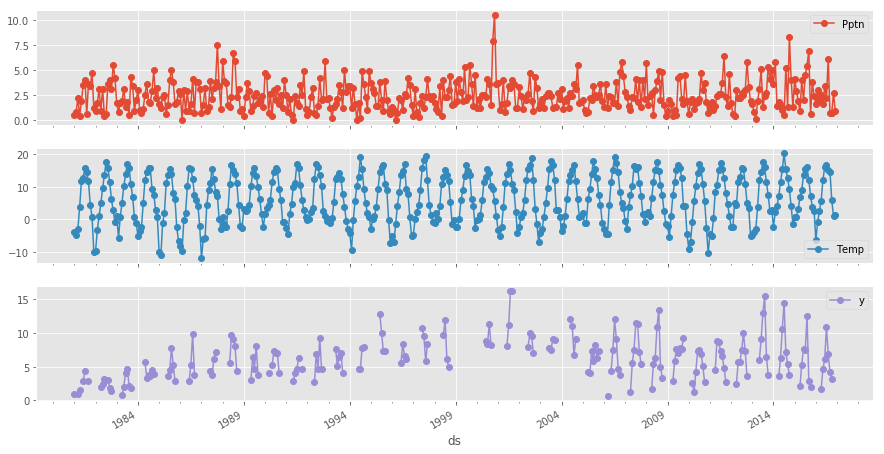

In [8]:
# Plot series
df.plot(subplots=True, marker='o', figsize=(15,8))
df.reset_index(inplace=True)

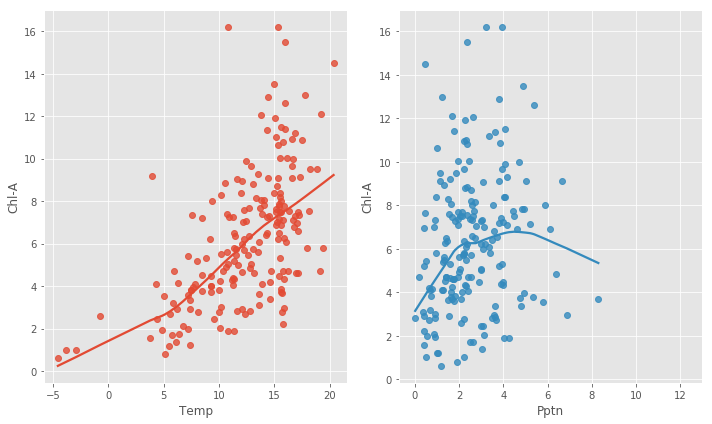

In [9]:
# Scatterplots with lowess smoothing
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

# Temp
sn.regplot(data=df, 
           x='Temp', 
           y='y',
           lowess=True, 
           ax=axes[0])
axes[0].set_ylabel('Chl-A')
axes[0].set_xlabel('Temp')

# Pptn
sn.regplot(data=df, 
           x='Pptn', 
           y='y',
           lowess=True, 
           ax=axes[1])
axes[1].set_ylabel('Chl-A')
axes[1].set_xlabel('Pptn')

plt.tight_layout()

There certainly appears to be a (possibly exponential?) relationship with temperature. Nothing very obvious for precipitation, though.

### 3.2 Monthly model without predictors

#### 3.2.1. Fit model

This section just uses the monthly data and patterns in Cla-a. This should give a baseline to work from. Note that I've set `'yearly_seasonality=5'` in the code below, as the default of 10 seemed too wiggly, so I've damped it out a bit. I'm also using an `'additive model'` to begin with.

In [10]:
# Fit model
m = Prophet(growth='linear',                 # Or 'logistic'
            seasonality_mode='additive',     # Or 'multiplicative'
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=5)            # Bigger => more flexibility in seasonality
m.fit(df)

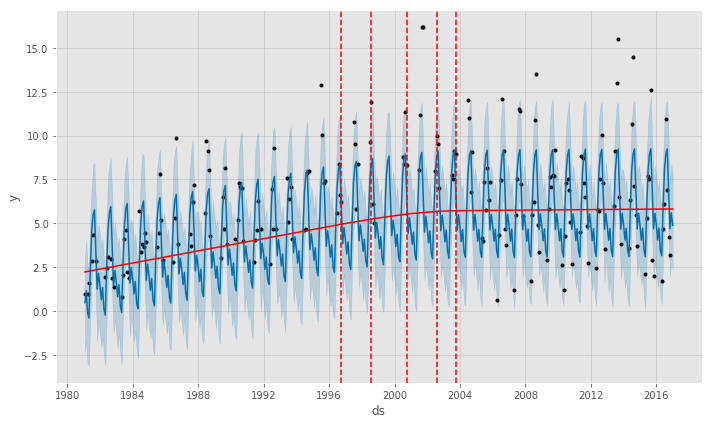

In [11]:
# Plot results (within-sample)
fcst = m.predict(df)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

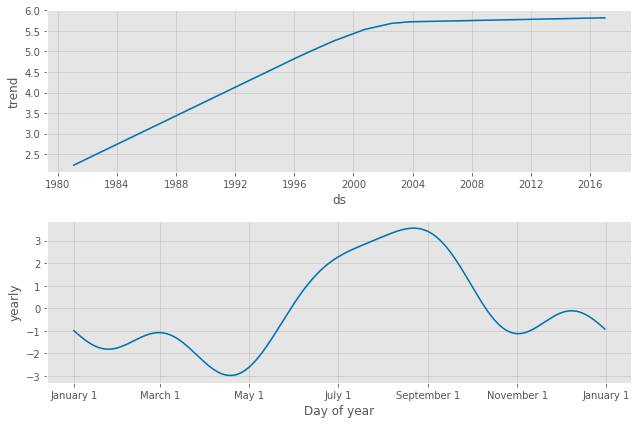

In [12]:
# Plot components
fig2 = m.plot_components(fcst)

These results are very similar to those from the daily model: a increasing trend with a break-point in the early 2000s, and a plausible annual growth cycle. The levelling-off trend is visible "by eye" in the raw data, but it looks a bit odd and I'm not sure whether it's real or an artifact (e.g. change in method)?

#### 3.2.2. Evaluate model

The code below tests the monthly model on different subsets of the data. To begin with, Prophet will use all *except* the last `'horizon'` of data to train the model, then make predictions for the final `'horizon'`. These predictions are then compared to the observations to estimate forecast skill. The model then steps back one `'period'` into the time series, and uses all the earlier data to train the model. It then makes predictions one `'horizon'` ahead again and evaluates the skill. This process is repeated, stepping back along the series and using all the data before each start point to train the model. Iteration stops when the model has less than `'initial'` data for training. This gives a set of evaluation data from which the average skill can be estimated.

In the code below, I make repeated forecasts 6 monthsahead, which seems reasonable for WaterXr. The model steps back through the series in 90 day increments, and always uses at least the first 10 years of data for training.

In [13]:
# CV making lots of 1-year forecasts (with at least 10 years of training data)
df_cv = cross_validation(m, initial='3650 days', horizon='180 days', period='90 days')
df_cv.head()

INFO:fbprophet:Making 73 forecasts with cutoffs between 1991-04-09 00:00:00 and 2016-05-04 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1991-05-31,5.843794,4.067590,7.768429,2.800000,1991-04-09
1,1991-06-30,6.787143,4.890362,8.806829,4.066667,1991-04-09
2,1991-07-31,7.138603,5.193260,8.928392,4.600000,1991-04-09
3,1991-08-31,8.068012,6.319904,9.928975,6.250000,1991-04-09
4,1991-07-31,6.847613,4.787875,8.864353,4.600000,1991-07-08


Prophet includes some in-built functions for visualising performance results. The code below shows a range of metrics for different forecast horizons, averaged with a rolling window.

In [14]:
# Performance stats. at different forcast lengths
df_p = performance_metrics(df_cv, rolling_window=0.1)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
7,25 days,8.089975,2.844288,2.327826,0.745668,0.608696
101,27 days,8.755813,2.959022,2.449072,0.778813,0.565217
180,27 days,8.668705,2.944266,2.403343,0.770245,0.565217
231,27 days,8.291137,2.879433,2.329914,0.775388,0.608696
109,30 days,8.411809,2.900312,2.398030,0.784290,0.608696


And the plot below shows the Mean Absolute Percentage Error (MAPE) for different forecast horizons, based on the results in `'df_cv'`. Note that the y-scale needs multiplying by 100 to get actual percentages.

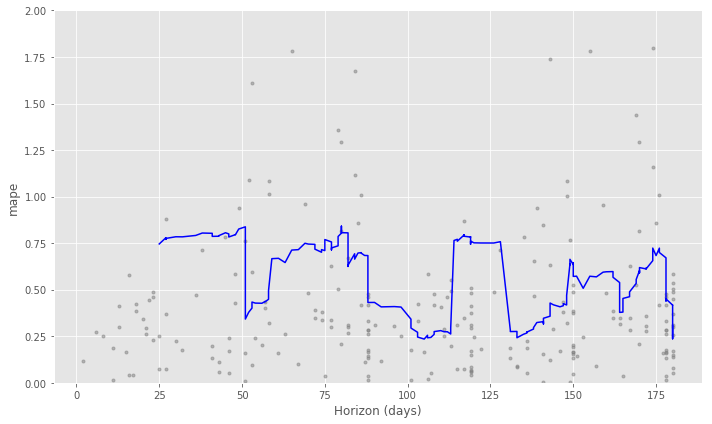

In [15]:
# Plot
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig = plt.gca()
fig.set_ylim((0,2))
plt.tight_layout()

However, while the built-in evaluation metrics are useful, they produce output that is difficult to interpret with our data. This because, with one or two exceptions, we only have Chl-a data during the spring and summer, so it is not fair to expect Prophet to make predictions during the winter months. In other words, the plots above suggest poor performance, but this is partly because the model is being asked to make "out-of-sample" predictions for conditions not represented in the training data. This is unfair, since for WateXr we're mostly interested in the ability to predict Chl-a from about April to October (when data are available). 

The function below is similar to `'plot_cross_validation_metric'`, except I'm summarising performance by month, to get a clearer idea of forecast skill during the time periods we're actually interested in.

In [16]:
def mape_by_month(cv_df, ax, metric):
    """ Summarise CV results by month using MAPE metric.
    
    Args
        cv_df:  Dataframe. Returned by cross_validation function in Prophet
        ax:     Matplotlib axis. To which plot will be added
        metric: Function. np.mean, np.median etc.
        
    Returns
        None. Plot added to axis.
    """
    import pandas as pd
    import seaborn as sn
    
    # Copy data
    cv = cv_df.copy()
    
    # Get months and MAPEs
    cv['month'] = cv['ds'].dt.month
    cv['mape'] = 100*np.abs(cv['yhat'] - cv['y'])/cv['y']

    sn.pointplot(data=cv, x='month', y='mape', 
                 estimator=metric, ax=ax)

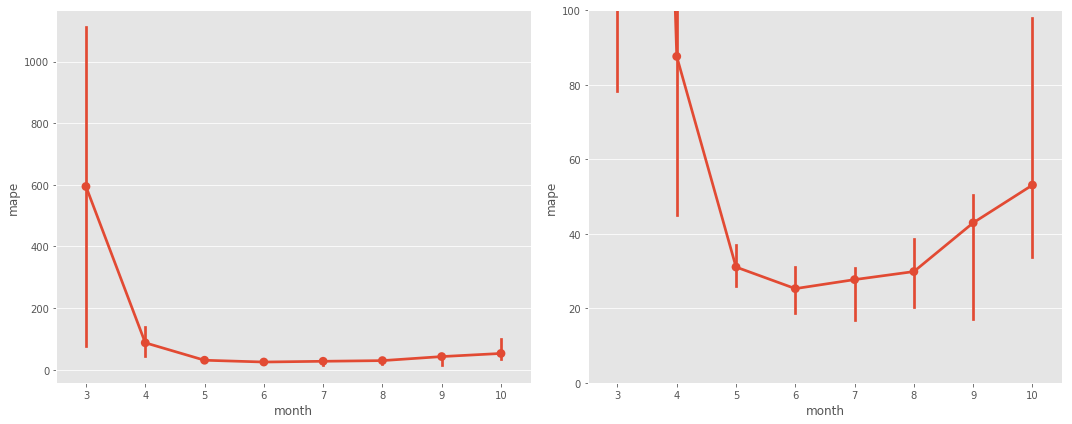

In [17]:
# Plot MAPE by month
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# Plot
mape_by_month(df_cv, axes[0], np.median)

# Zoom in on region of interest
mape_by_month(df_cv, axes[1], np.median)
axes[1].set_ylim((0,100))
plt.tight_layout()

This plot is easier to interpret. It is clear that the model is very bad at predicting Chl-a during March, but this is not surprising, as very little training data are available in this period. Errors are also large (>80%) for April, but for the other months things are more promising. For the four key months of May to August, errors are typically around 30%, which is not great, but not terrible either.

### 3.3. Multiplicative model

Before exploring the effects of additional predictors, it's worth seeing whether a `'multiplicative'` model is any better.

In [18]:
# Fit model
m = Prophet(growth='linear',                       # Or 'logistic'
            seasonality_mode='multiplicative',     # Or 'additive'
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=5)                  # Bigger => more flexibility in seasonality
m.fit(df)

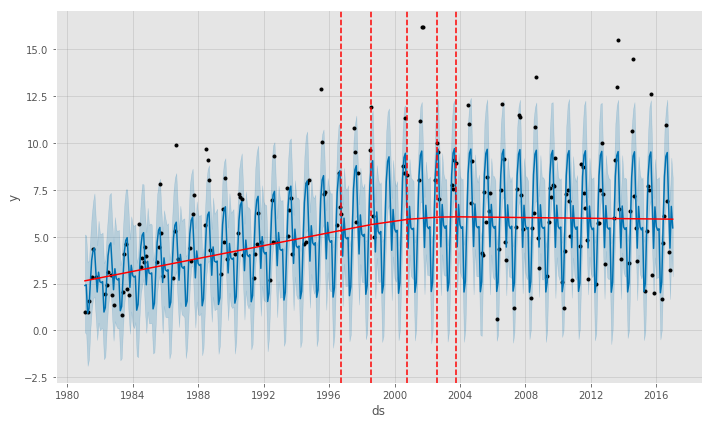

In [19]:
# Plot results (within-sample)
fcst = m.predict(df)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

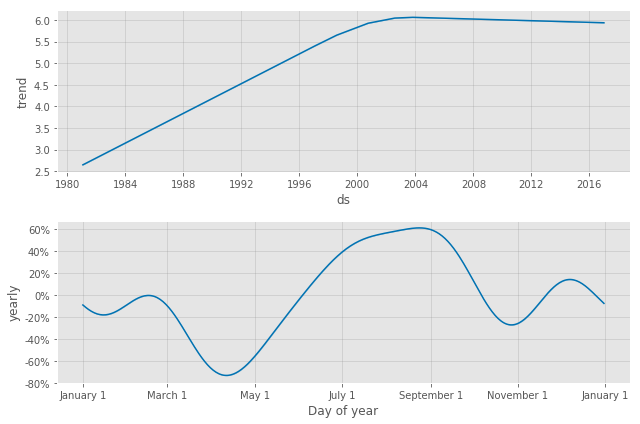

In [20]:
# Plot components
fig2 = m.plot_components(fcst)

This doesn't look much different by eye, but note that the "yearly" component is now expressed as a percentage change, rather than as an additive component, as above.

In [21]:
# CV making lots of 1-year forecasts (with at least 10 years of training data)
df_cv = cross_validation(m, initial='3650 days', horizon='180 days', period='90 days')
df_cv.head()

INFO:fbprophet:Making 73 forecasts with cutoffs between 1991-04-09 00:00:00 and 2016-05-04 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1991-05-31,5.611635,3.693403,7.428004,2.800000,1991-04-09
1,1991-06-30,7.644035,5.714495,9.532735,4.066667,1991-04-09
2,1991-07-31,7.682231,5.816397,9.618445,4.600000,1991-04-09
3,1991-08-31,9.402379,7.606399,11.371958,6.250000,1991-04-09
4,1991-07-31,7.378224,5.510857,9.316460,4.600000,1991-07-08


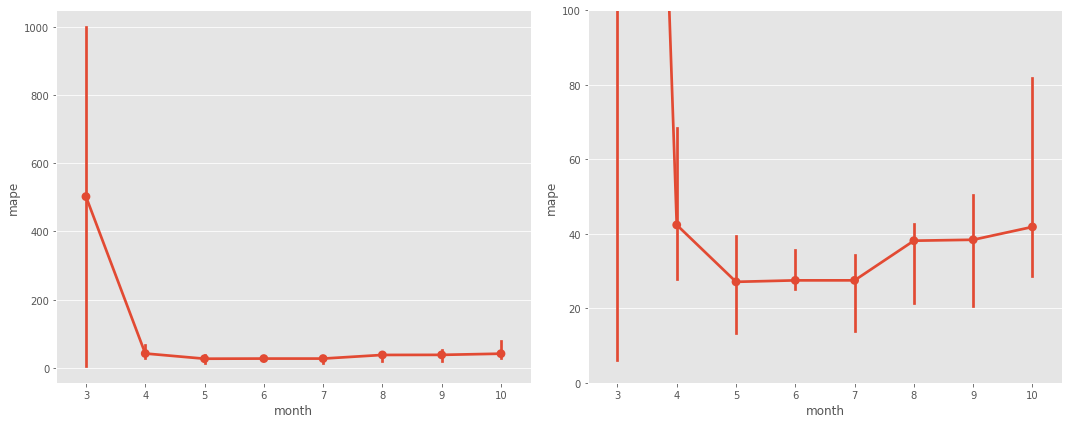

In [22]:
# Plot MAPE by month
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# Plot
mape_by_month(df_cv, axes[0], np.median)

# Zoom in on region of interest
mape_by_month(df_cv, axes[1], np.median)
axes[1].set_ylim((0,100))
plt.tight_layout()

This looks like a significant improvement. Errors for March are still huge, but predictive skill for the other months has generally improved. Predictions are also more consistent (i.e. the error bars for some months have become smaller). Errors for April are now just over 40% (c.f. >80% above), and those for May to July are still around 30%. The only month for which predictions from this model are slightly worse is August: errors are about 40% here, compared to 30% above.

### 3.4. Add temperature as a predictor

I'll stick with a multiplicative model for now, as this seems best based on the results above.

In [23]:
# Fit model
m = Prophet(growth='linear',                 # Or 'logistic'
            seasonality_mode='multiplicative',     # Or 'additive'
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=5)            # Bigger => more flexibility in seasonality
m.add_regressor('Temp')
m.fit(df)

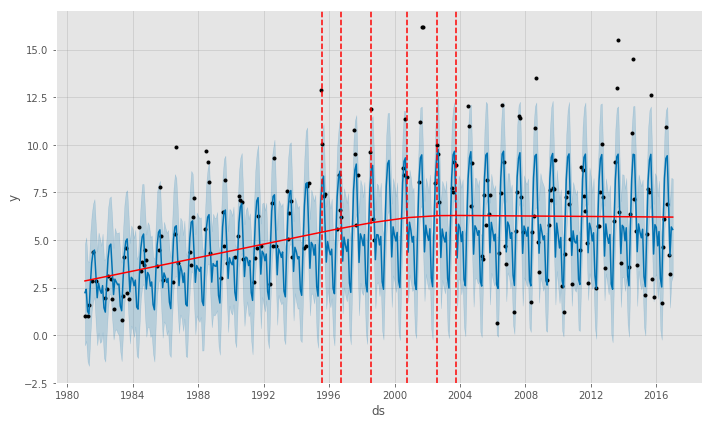

In [24]:
# Plot results (within-sample)
fcst = m.predict(df)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

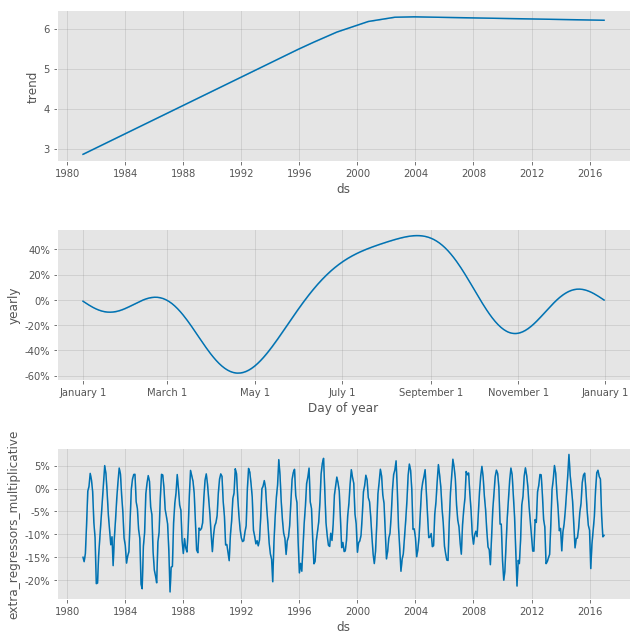

In [25]:
# Plot components
fig2 = m.plot_components(fcst)

This model looks virtually identical to the one without temperature as a predictor. Looking at the component plot above, the reason why seems obvious: the "yearly" component picked out automatically by Prophet is a good proxy for temperature, which means the additional predictor adds little extra information. Based on the plots above, the "yearly" component is accounting for changes in Chl-a of around -60 to +40%, whereas temperature accounts for only -20 to +5%.

The cross-validation results (below) are pretty similar too; if anything, predictions have become slightly worse for April, but are otherwise more-or-less unchanged.

INFO:fbprophet:Making 73 forecasts with cutoffs between 1991-04-09 00:00:00 and 2016-05-04 00:00:00


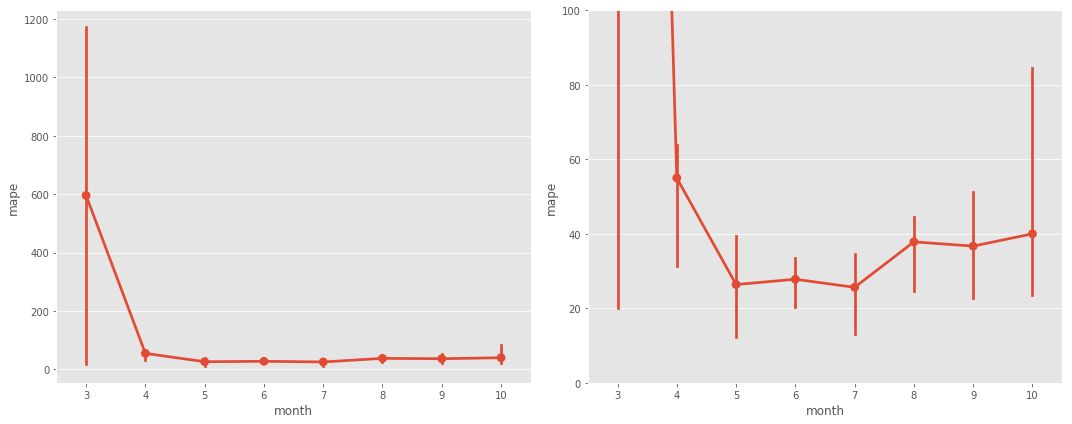

In [26]:
# CV making lots of 1-year forecasts (with at least 10 years of training data)
df_cv = cross_validation(m, initial='3650 days', horizon='180 days', period='90 days')

# Plot MAPE by month
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# Plot
mape_by_month(df_cv, axes[0], np.median)

# Zoom in on region of interest
mape_by_month(df_cv, axes[1], np.median)
axes[1].set_ylim((0,100))
plt.tight_layout()

## 4. Other models

The work so far suggests 3 possible alternative models:

 1. Use (log-transfromed) OLS regression to estimate Chl-a directly from the temperature record. This is probably not "statistically valid", as the errors will almost certainly be autocorrelated, but it might nevertheless actually work quite well. If assessed using the same or similar cross-validation techniques as above, we can worry less about error structures and more about what's practically useful <br><br>
 
 2. Turn off the "yearly" component in Prophet and fit temperature instead. This should increase the influence of the temperature variable, but probably won't dramatically improve the quality of forecasts <br><br>
 
 3. Calculate a new variable as $exp(Temp)$ and try adding this, either with or without the "yearly" component. I don't fully understand how Prophet treats additional predictors, but from the scatterplot above it looks as though there's an approximately exponential relationship between Chl-a and temperature, so transforming temperature first might increase it's importance. This would also be a good reason to use a multiplicative model, as the basic idea would be that $Chl_a \propto exp(T)$ i.e. multiply $exp(T)$ by a constant to roughly get Chl-a
 
Of these, (2) is easiest, followed by (3), and then (1).

### 4.1. Turn off "yearly" component

In [27]:
# Fit model
m = Prophet(growth='linear',                 
            seasonality_mode='multiplicative', 
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False)            
m.add_regressor('Temp')
m.fit(df)

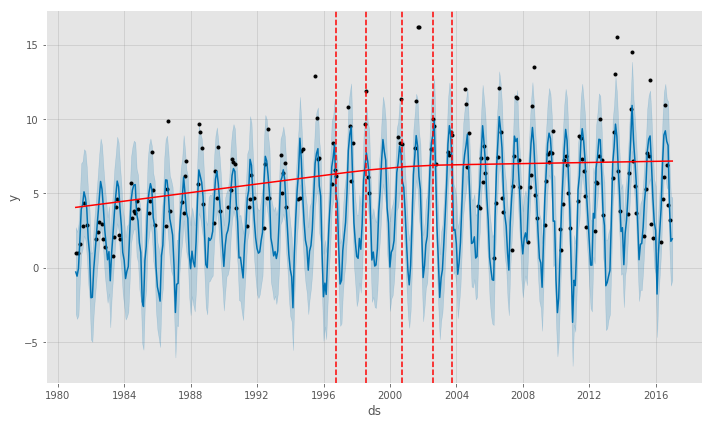

In [28]:
# Plot results (within-sample)
fcst = m.predict(df)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

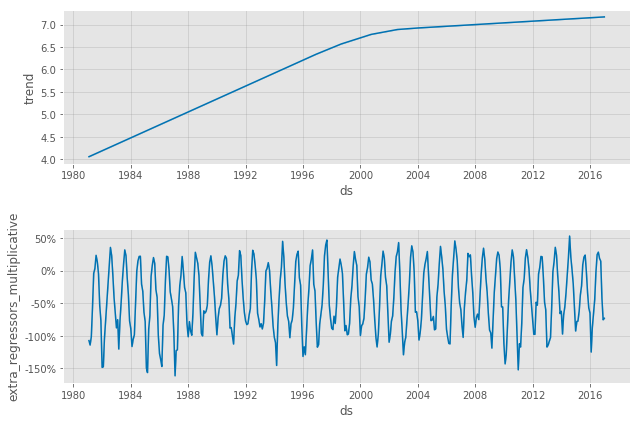

In [29]:
# Plot components
fig2 = m.plot_components(fcst)

INFO:fbprophet:Making 73 forecasts with cutoffs between 1991-04-09 00:00:00 and 2016-05-04 00:00:00


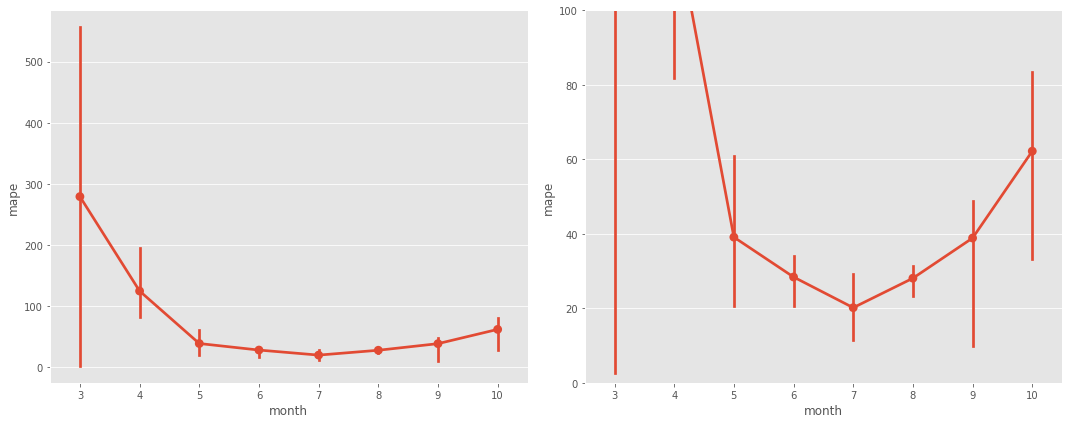

In [30]:
# CV making lots of 1-year forecasts (with at least 10 years of training data)
df_cv = cross_validation(m, initial='3650 days', horizon='180 days', period='90 days')

# Plot MAPE by month
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# Plot
mape_by_month(df_cv, axes[0], np.median)

# Zoom in on region of interest
mape_by_month(df_cv, axes[1], np.median)
axes[1].set_ylim((0,100))
plt.tight_layout()

The weight allocated to temperature has increased a lot, but overall this looks like a slightly worse model. Predictions for Chl-a are now sometimes negative, because air temperature gets very low during the winter and we don't have data at these times to constrain the model. This is not necessarily a major issue, as we aren't interested in predictions during these months, but the CV results are also generally worse (and with a big increase in variability). The only predictions that seem to have improved are those for July, which now has median errors of around 20%, rather than 30%.

### 4.2. Use $exp(T)$ instead

**Note:** I initially tried using $exp(T)$ with the "yearly" seasonality turned off, but this resulted in a terrible model, because the exponentiated temperature series no longer acts as a good proxy for the seasonality in the Chl-a record. Turning `'yearly_seasonality'` on gives some interesting results, because the temperature record then mostly has no influence, except on a few key dates where the temperature effect "spikes" to above 10%, which is comparable to the seasonal effects. Nevertheless, overall model performance seems slightly worse - and certainly no better - than the basic multiplicative model using just the Chl-a data (see plots below).

In [31]:
# Calc exp(T)
df['exp_T'] = np.exp(df['Temp'])

# Fit model
m = Prophet(growth='linear',                 
            seasonality_mode='multiplicative', 
            daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=5)            
m.add_regressor('exp_T')
m.fit(df)

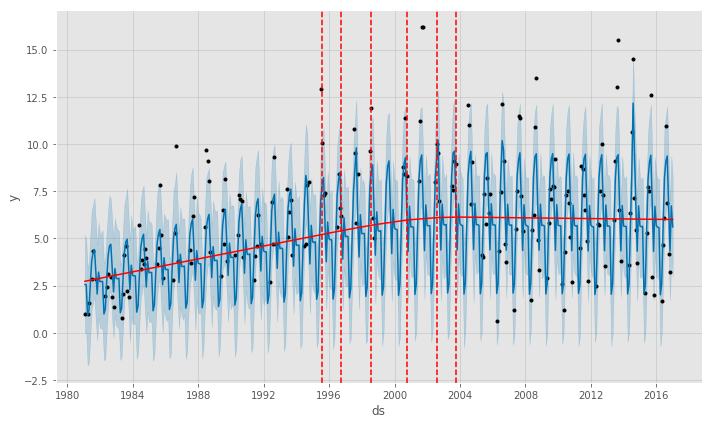

In [32]:
# Plot results (within-sample)
fcst = m.predict(df)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

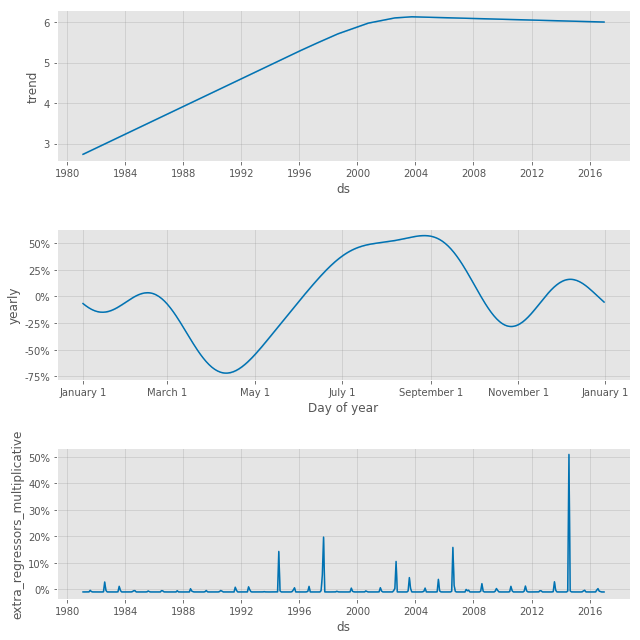

In [33]:
# Plot components
fig2 = m.plot_components(fcst)

INFO:fbprophet:Making 73 forecasts with cutoffs between 1991-04-09 00:00:00 and 2016-05-04 00:00:00


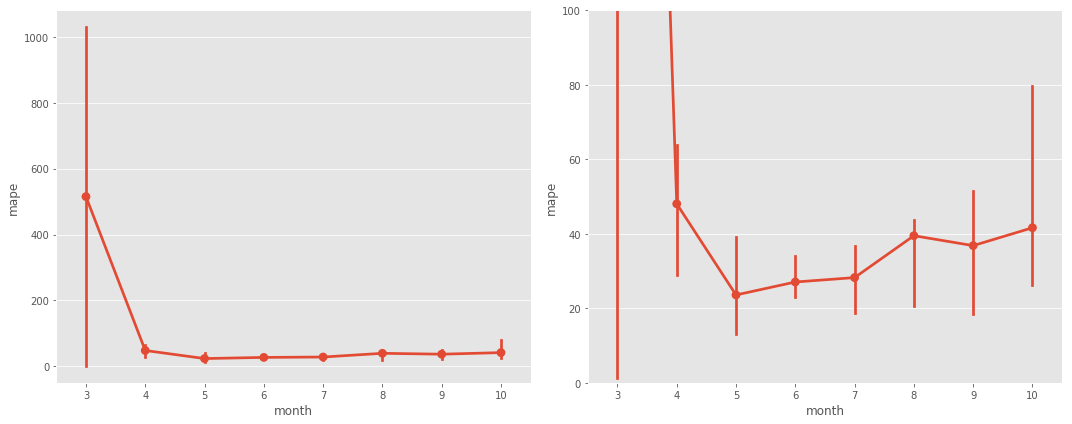

In [34]:
# CV making lots of 1-year forecasts (with at least 10 years of training data)
df_cv = cross_validation(m, initial='3650 days', horizon='180 days', period='90 days')

# Plot MAPE by month
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# Plot
mape_by_month(df_cv, axes[0], np.median)

# Zoom in on region of interest
mape_by_month(df_cv, axes[1], np.median)
axes[1].set_ylim((0,100))
plt.tight_layout()

### 4.3. OLS regression

Testing OLS regression in a comparable way will require a bit more work.

In [35]:
horizon = '180 days'
initial = '3650 days'
period = '90 days'

In [36]:
# Copy data
df2 = df.copy()
df2.index = df2['ds']

# Get stop date
stop_dt = df2['ds'].iloc[0] + pd.Timedelta(initial)
end_dt = df2['ds'].iloc[-1]
cut_dt = end_dt - pd.Timedelta(horizon)

# Container for results
df_list = []

# Step over time series
while cut_dt > stop_dt: 
    # Split series at cut_dt
    train_df = df2.truncate(after=cut_dt)
    test_df = df2.truncate(before=cut_dt, after=(cut_dt + pd.Timedelta(horizon)))

    # Fit linear model to log(y)
    mod = smf.ols(formula='np.log(y) ~ Temp', data=train_df)
    res = mod.fit()
    
    # Predict log(y) for test data
    test_df['yhat'] = np.exp(res.predict(test_df['Temp']))
    df_list.append(test_df.copy())
    
    # decrement cutoff
    cut_dt -= pd.Timedelta(period)

# Combine results
ols_df = pd.concat(df_list, axis=0)
ols_df.head()

,ds,Pptn,Temp,y,exp_T,yhat
ds,,,,,,
2016-07-31,2016-07-31,2.196774,16.646774,10.95,1.696689e+07,8.056642
2016-08-31,2016-08-31,6.109677,15.164516,6.90,3.853592e+06,7.014915
2016-09-30,2016-09-30,0.633333,14.578333,4.20,2.144321e+06,6.641136
2016-10-31,2016-10-31,0.700000,5.880645,3.20,3.580402e+02,2.947122
2016-11-30,2016-11-30,2.663333,1.011667,NaN,2.750181e+00,1.870145


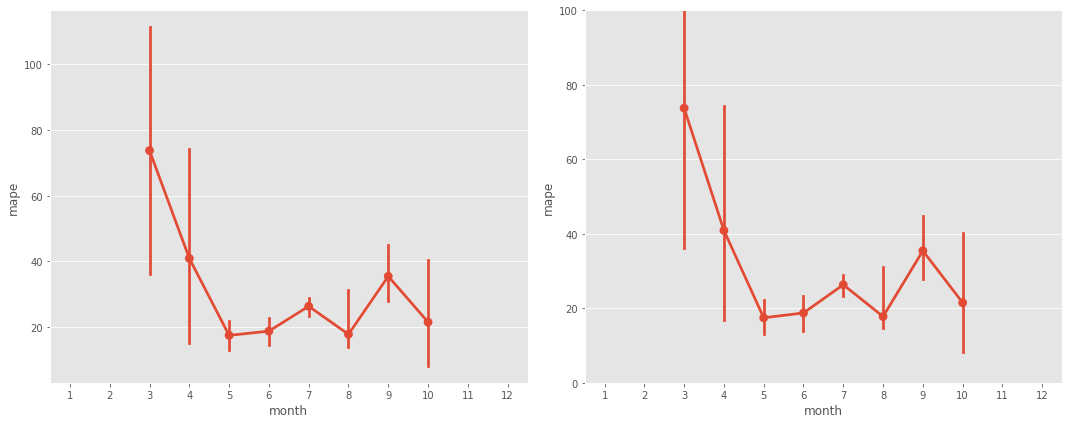

In [37]:
# Plot MAPE by month
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# Plot
mape_by_month(ols_df, axes[0], np.median)

# Zoom in on region of interest
mape_by_month(ols_df, axes[1], np.median)
axes[1].set_ylim((0,100))
plt.tight_layout()

In [39]:
# Regression on whole dataset
mod = smf.ols(formula='np.log(y) ~ Temp', data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              np.log(y)   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     162.5
Date:                Mon, 25 Feb 2019   Prob (F-statistic):           2.72e-27
Time:                        15:59:27   Log-Likelihood:                -112.41
No. Observations:                 192   AIC:                             228.8
Df Residuals:                     190   BIC:                             235.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5320      0.096      5.554      0.0

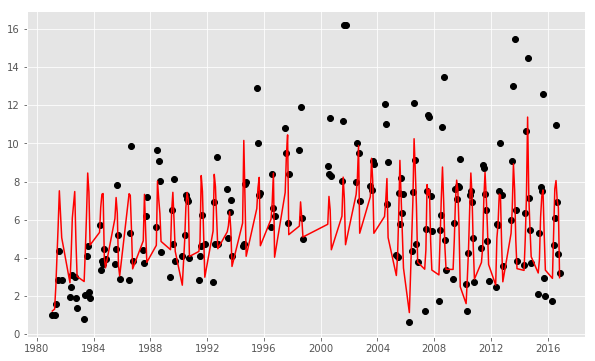

In [41]:
# Plot predicted (within-sample)
fig = plt.figure(figsize=(10,6))
plt.plot(df2['ds'], df2['y'], 'ko')
plt.plot(df2.dropna(subset=['y'])['ds'], np.exp(res.fittedvalues), 'r-')

Interestingly, using $Chla = exp(0.09T + 0.53)$ does a reasonable job of picking up the step-change in Chl-a around 2005.

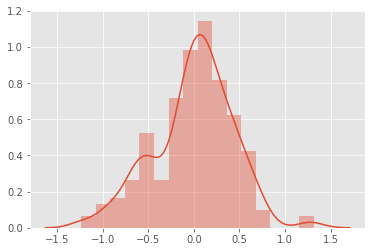

In [42]:
# Residuals
sn.distplot(res.resid)

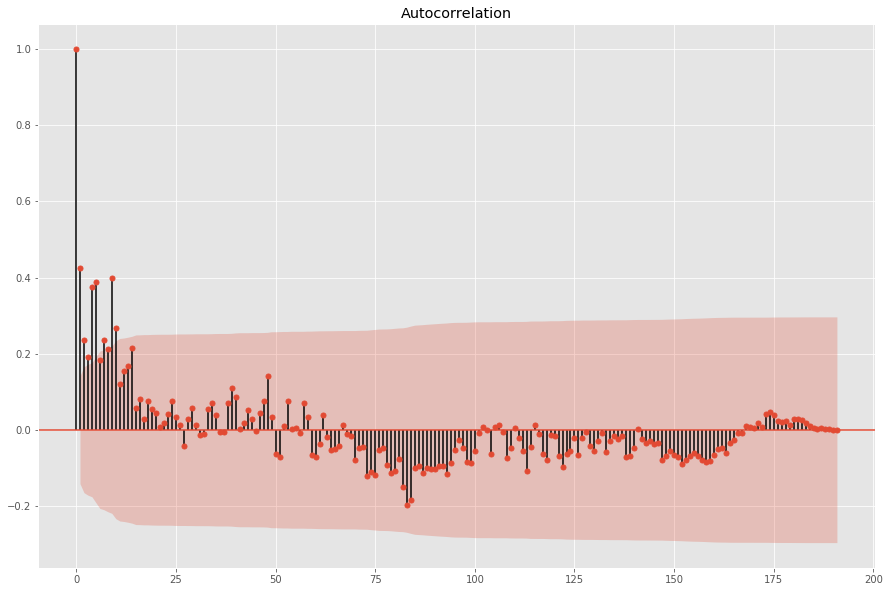

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
acf = plot_acf(res.resid, ax=ax)

In [79]:
# Copy data
df2 = df.copy()
df2['cap'] = df2['y'].max()

# Fit linear model to log(y)
m = Prophet(growth='logistic',                 
            seasonality_mode='multiplicative',
            yearly_seasonality=False,
            changepoint_prior_scale=0.5) 
m.add_regressor('Temp')
m.fit(df2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


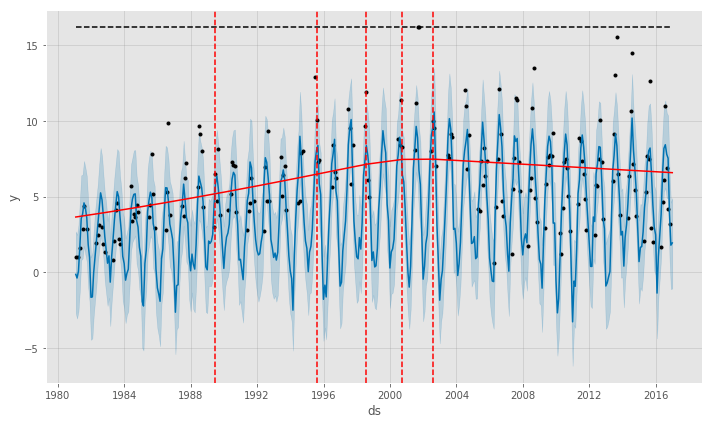

In [80]:
# Plot results (within-sample)
fcst = m.predict(df2)
fig = m.plot(fcst)
a = add_changepoints_to_plot(fig.gca(), m, fcst)

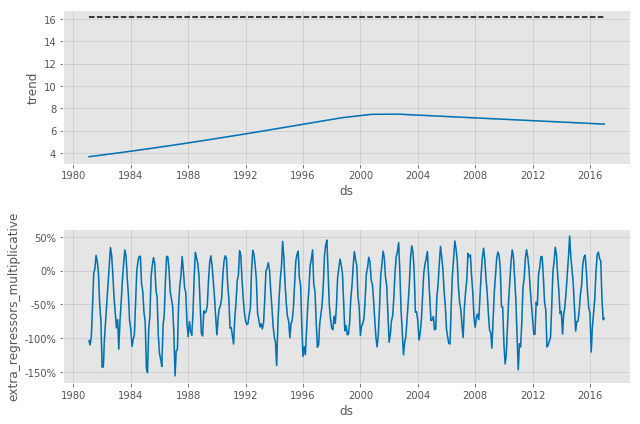

In [81]:
# Plot components
fig2 = m.plot_components(fcst)

INFO:fbprophet:Making 73 forecasts with cutoffs between 1991-04-09 00:00:00 and 2016-05-04 00:00:00


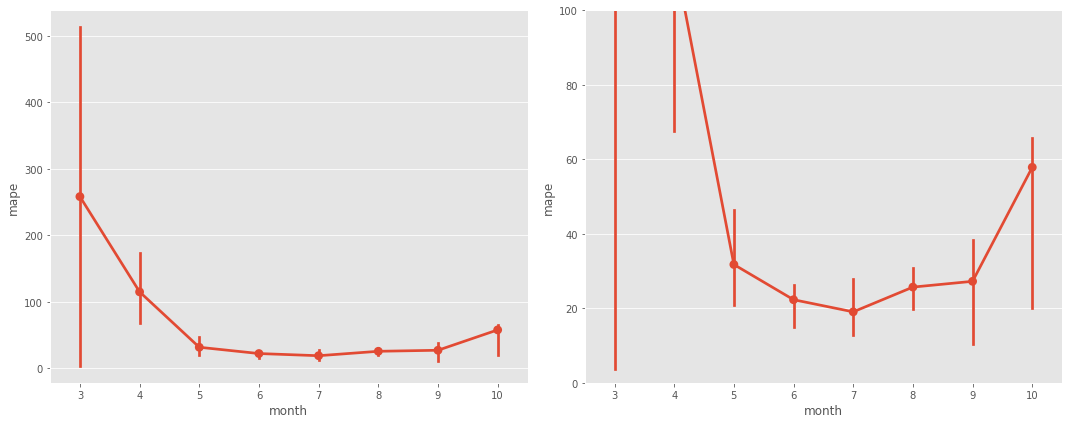

In [68]:
# CV making lots of 1-year forecasts (with at least 10 years of training data)
df_cv = cross_validation(m, initial='3650 days', horizon='180 days', period='90 days')

# Plot MAPE by month
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# Plot
mape_by_month(df_cv, axes[0], np.median)

# Zoom in on region of interest
mape_by_month(df_cv, axes[1], np.median)
axes[1].set_ylim((0,100))
plt.tight_layout()